## Practice Script on Stacking Model

Hello all, this is my first post of machine learning practice on Kaggle. Some of the ideas and implementations may be worth for further refinement, but through this sharing I hope we can encourage more idea sharing and discussions for more different analysis practices. Feel free to leave any comment then.

### <span style="color:#1F618D">The purpose of this practice:</span>
* Get familar with how to train a `XGBoost` model and fine-tune its parameters
* Know how to implement `Stacking Model Method`, this will be also the script for practicing stacking models without and with parameters fine-tuning.
* The first time to address dataset with a bunch of features (more than 80 features) and handle them in a system manner, with minimal human interpretation and intervention.
* Have a chance to practice writing a class.

### <span style="color:#1F618D">Especial thanks and reference to the following authors and notebooks</span>  
* [Stacked Regressions to predict House Prices](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard/notebook)
* [Jump-start script for Competitive Data Science @ Tel Aviv Meetup](https://github.com/dremovd/cds-ta-meetup/blob/master/Allstate%20jump-start.ipynb)
* [StackingCVRegressor Example](https://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/#example-2-gridsearchcv-with-stacking)

### <span style="color:#1F618D">The structure of the analysis practice will be implemented in the following manner:</span>
1. [step link](#01) First combine the train and test dataset together, so we can utilize more information, for the purpose of data pre-processing.
2. [step link](#02) Check up the missing value and its frequency.
3. [step link](#03) Re-code some categorical features if these features are ordinal in nature. This will take reference from [the template jupyter nootbook](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard/notebook). `series.replace` is one of the choice.
4. [step link](#04) Impute the missing values - using `K Nearest Neighbors Method (k=7)`, both on categorical and numerical feature.
    - a. use the completed numerical features as inputs to calculate the distance among data points.
    - b. for categorical feature, it will be the `mode` value of that feature in k neighbors.
    - c. for numerical feature, it will be the `average` value of that feature in k neighbors.
5. [step link](#05) Visualization on the distribution of target feature `SalePrice`.
6. [step link](#06) Visualization on the distribution of input numerical (both integer and float) features.
7. [step link](#07) `Normality Test` on these features (target and inputs), filter the ones needed for `Boxcox` transformation.
    - a. `shapiro` is used to test normality.
    - b. recording the skewness of each feature.
    - c. `scipy.stats.boxcox` is used for transformation.
    - d. recording the `lmbda` used for each feature. For future feature reversion to original scale. 
    - e. compare the skewness of original scale and Boxcox transformed scale.
8. [step link](#08) Convert all categorical features into dummies, for the purpose of modeling.
9. [step link](#09) Single Modeling Phase, use grid-search to fine tune parameters for each model as well.
    - a. XGBoost
    - b. SVM
    - c. Linear Lasso Model
    - d. AdaBoost
10. [step link](#10) Stacking Modeling Phase, practice two different methods:
    - a. Self-define class for base model. This will simply use the average value from ensemble base models. No meta-model is used yet.
    - b. The meta model will use simple linear model. And use the existing module `mlxtend` to implement stacking model. The meta model will remain as default parameters, keeping it as simple as possible.
11. [step link](#11) Compare the improvement of error on single model, stakcing model without fine-tuning, stacking model with fine-tuning. Also have a look at the predicted outcome in original scale. 


**[change the font color of markdown text](https://stackoverflow.com/questions/35465557/how-to-apply-color-in-markdown)**

<a id="01"></a>
## <span style="color:#922B21">1. Read in and Combine train, test dataset</span>

In [4]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

# show all columns
pd.set_option('display.max_columns', 500)

# suppress warnings
import warnings 
warnings.simplefilter('ignore')


from subprocess import check_output
print(check_output(["ls"]).decode("utf8"))


20180630_Practice_stacking_model.ipynb
test.csv
train.csv



**[pandas set options](https://stackoverflow.com/questions/11707586/python-pandas-how-to-widen-output-display-to-see-more-columns#answers)**


In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [6]:
# remove unnecessary column
train_id = train['Id']
test_id = test['Id']
train.drop('Id', axis = 1, inplace=True)
test.drop('Id', axis = 1, inplace=True)

In [7]:
ntrain = train.shape[0]
ntest = test.shape[1]
print('train shape:', train.shape)
print('test shape:', test.shape)

SalePrice = train['SalePrice'].values

# create dataset flag
train['DataSet'] = 'train'
test['DataSet'] = 'test'

# 'SalePrice' will be excluded because of inner concatenation
all_data = pd.concat([train, test], ignore_index=True, join='inner')
print('Is column SalePrice in the dataset:' ,'SalePrice' in all_data.columns)

print('all data shape:', all_data.shape)
all_data.head(n=2)


train shape: (1460, 80)
test shape: (1459, 79)
Is column SalePrice in the dataset: False
all data shape: (2919, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,DataSet
0,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706.000,Unf,0.000,150.000,856.000,GasA,Ex,Y,SBrkr,856,854,0,1710,1.000,0.000,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2.000,548.000,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,train
1,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.000,Unf,0.000,284.000,1262.000,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.000,1.000,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2.000,460.000,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,train


<a id="02"></a>
## <span style="color:#922B21">2. Check up the frequency of missing value</span>

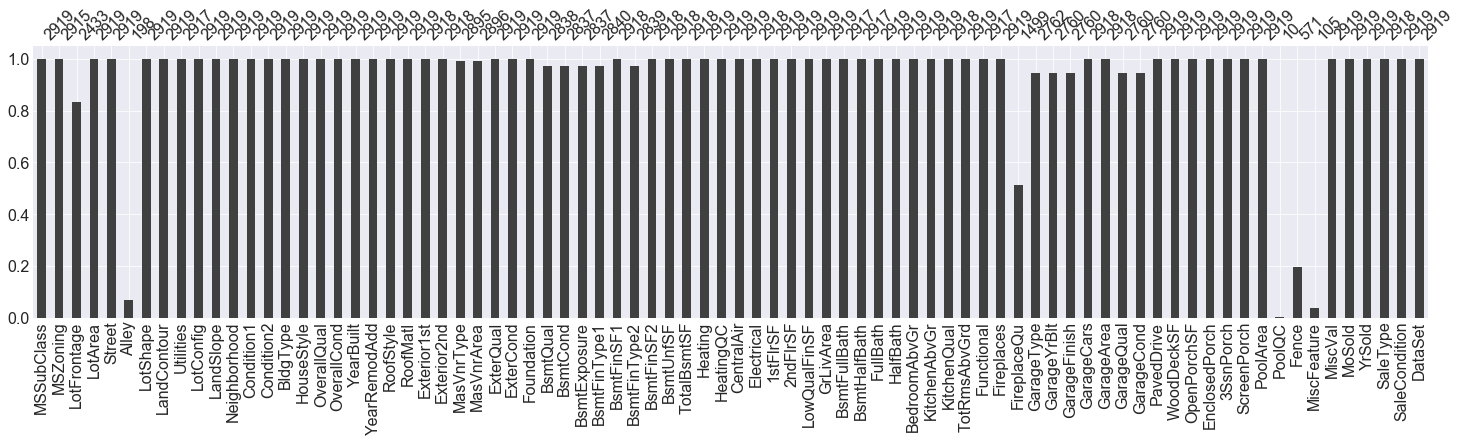

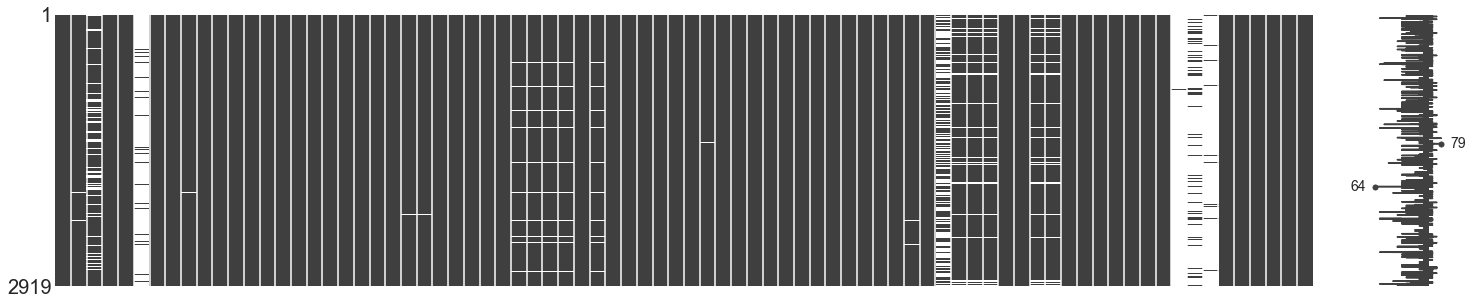

In [8]:
import missingno as msno

msno.bar(all_data, figsize=(25,5)) # show up the percentage of missing values in each column
msno.matrix(all_data, figsize=(25,5)) # show up the distribution of missing values in each row

In [9]:
# calculate the frequency of missing value

from operator import itemgetter

missing = (all_data.isnull().sum()/all_data.shape[0])
missing = zip(missing.index.values, missing)

# zip() in conjunction with the * operator can be used to unzip a list
ind, missing = zip(*sorted(missing, key=itemgetter(1), reverse=True))
missing = pd.DataFrame(np.array(missing), index=ind, columns=["MissingRate"])
missing.head(n=10)

,MissingRate
PoolQC,0.997
MiscFeature,0.964
Alley,0.932
Fence,0.804
FireplaceQu,0.486
LotFrontage,0.166
GarageYrBlt,0.054
GarageFinish,0.054
GarageQual,0.054
GarageCond,0.054


**<span style="color:#78281F">As we can tell, there are a few features with missing rate above 90%, it's better to exclude them. But in the whole dataset, most features have relatively completed records, with missing rate around 5% or less.</span>**

**how to sort a dataset**<br/>
[using operator.itemgetter](https://stackoverflow.com/questions/7851077/how-to-return-index-of-a-sorted-list#answer-7851186)<br/>
[zip](https://docs.python.org/3.4/library/functions.html#zip)

In [10]:
# drop out feature of missing rate above 90%
drop_col = missing.loc[missing['MissingRate'] > 0.9].index.values
all_data_sub = all_data.drop(columns=drop_col)

<a id="03"></a>
## <span style="color:#922B21">3. Re-code String Label to Ordinal Number</span>

**This way, we can include more information from the ordinal.**

In [11]:
# Through observation, the column name ends with `Qul` or `Cond` are the ones needed to be re-code into ordinal value

col_set1 = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC',
       'KitchenQual','FireplaceQu','GarageQual','GarageCond']

col_set2 = ['BsmtExposure']

col_set3 = ['BsmtFinType1','BsmtFinType2']

col_set4 = ['GarageFinish']

col_set5 = ['Fence']


# create a mapper for value replacement

mapper_set1 = {'NA':0,
               'Po':1,
               'Fa':2,
               'TA':3,
               'Gd':4,
               'Ex':5}

mapper_set2 = {'NA':0,
               'No':1,
               'Mn':2,
               'Av':3,
               'Gd':4}

mapper_set3 = {'NA':0,
               'Unf':1,
               'LwQ':2,
               'Rec':3,
               'BLQ':4,
               'ALQ':5,
               'GLQ':6}

mapper_set4 = {'NA':0,
               'Unf':1,
               'RFn':2,
               'Fin':3}

mapper_set5 = {'NA':0,
               'MnWw':1,
               'GdWo':2,
               'MnPrv':3,
               'GdPrv':4}

# when we read in the dataset, the NA value is mis-interpreted as null value
def replaceNa(df,col):
    for x in col:
        print('column {} null value is replaced to NA:'.format(x), df[x].isnull().any())
        df[x].fillna('NA', inplace=True)


replaceNa(all_data_sub, col_set1)
replaceNa(all_data_sub, col_set2)
replaceNa(all_data_sub, col_set3)
replaceNa(all_data_sub, col_set4)
replaceNa(all_data_sub, col_set5)

def printUniqueValue(df, col):
    for x in col:
        print('unique value of column {}:'.format(x), df[x].unique())

printUniqueValue(all_data_sub, col_set1)
printUniqueValue(all_data_sub, col_set2)
printUniqueValue(all_data_sub, col_set3)
printUniqueValue(all_data_sub, col_set4)
printUniqueValue(all_data_sub, col_set5)

def replaceToOrdinalNum(df, col, mapper):
    for x in col:
        df[x].replace(to_replace=mapper, inplace=True)
        print('column {} new replaced value:'.format(x), df[x].unique())

replaceToOrdinalNum(all_data_sub, col_set1, mapper_set1)
replaceToOrdinalNum(all_data_sub, col_set2, mapper_set2)
replaceToOrdinalNum(all_data_sub, col_set3, mapper_set3)
replaceToOrdinalNum(all_data_sub, col_set4, mapper_set4)
replaceToOrdinalNum(all_data_sub, col_set5, mapper_set5)

column ExterQual null value is replaced to NA: False
column ExterCond null value is replaced to NA: False
column BsmtQual null value is replaced to NA: True
column BsmtCond null value is replaced to NA: True
column HeatingQC null value is replaced to NA: False
column KitchenQual null value is replaced to NA: True
column FireplaceQu null value is replaced to NA: True
column GarageQual null value is replaced to NA: True
column GarageCond null value is replaced to NA: True
column BsmtExposure null value is replaced to NA: True
column BsmtFinType1 null value is replaced to NA: True
column BsmtFinType2 null value is replaced to NA: True
column GarageFinish null value is replaced to NA: True
column Fence null value is replaced to NA: True
unique value of column ExterQual: ['Gd' 'TA' 'Ex' 'Fa']
unique value of column ExterCond: ['TA' 'Gd' 'Fa' 'Po' 'Ex']
unique value of column BsmtQual: ['Gd' 'TA' 'Ex' 'NA' 'Fa']
unique value of column BsmtCond: ['TA' 'Gd' 'NA' 'Fa' 'Po']
unique value of colu

**<span style="color:#212F3D">Replace values</span>**<br/>
**[replace value in a series](https://stackoverflow.com/questions/29528628/how-to-specify-a-variable-in-pandas-as-ordinal-categorical#answer-41875178)**<br/>
**[replace value of columns in a dataframe](https://pandas.pydata.org/pandas-docs/version/0.22.0/generated/pandas.DataFrame.replace.html)**

<a id="04"></a>
## <span style="color:#922B21">4. Impute The Missing Value</span>

**First, use the completed numerical features as input for KNN distance calculation. Then, identify similar neighbors and impute the missing categorical and numerical features.**

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

def completeNumCol(df):
    '''return no-na numerical column names'''
    col = []
    # filter numerical column
    for x in df.columns.values:
        if df[x].dtype in (float,int):
            col.append(x)
    
    # filter no na col
    no_nan = df[col].isnull().any() == False
    col = list(no_nan.index.values[no_nan == True])
    return col

def noncompleteNumCol(df):
    '''return exist-na numerical column names'''
    col = []
    # filter numerical column
    for x in df.columns.values:
        if df[x].dtype in (float,int):
            col.append(x)
    
    # filter has na col
    has_nan = df[col].isnull().any() == True
    col = list(has_nan.index.values[has_nan == True])
    return col

def categoricalCol(df):
    '''return categorical column names'''
    # impute all categorical feature
    cat_col = []
    for x in df.columns.values:
        if df[x].dtype == object:
            cat_col.append(x)
    return cat_col


def imputeNumCol(df, num_col, fit_col):
    '''use no-na numerical column to calculate the distance among data points
        and impute the numerical column existing NA'''
    df = df.copy()
    for i in num_col:
        fit_col.append(i) # include y to check up for na
        knn_train = df[fit_col].dropna() # ensure no na value in train dataset
    
        knn_train_y = knn_train[i]
    
        std_scaler = StandardScaler()
        knn_train_x = knn_train.drop(columns=i) # drop y col
        std_scaler.fit(knn_train_x) # standardize for knn
        std_knn_train_x = std_scaler.transform(knn_train_x)
    
        neigh = KNeighborsRegressor(n_neighbors=7)
        neigh.fit(std_knn_train_x,knn_train_y)

        na_ind = df[df[i].isnull()].index.values # identify na index for y col
        fit_col.remove(i) # remove y col
        
        test_x = df[fit_col] # for knn prediction
        std_test_x = std_scaler.transform(test_x) 
        
        if not len(na_ind) == 0:
            value = neigh.predict(test_x.iloc[na_ind]) # predict y col on na rows
            df[i][na_ind]= value
        else:
            continue

    return df


def imputeCatCol(df, cat_col, fit_col):
    '''use no-na numerical column to calculate the distance among data points
        and impute the categorical column existing NA'''    
    df = df.copy()
    for i in cat_col:
        fit_col.append(i) # include y to check up for na
        knn_train = df[fit_col].dropna() # ensure no na value in train dataset
    
        knn_train_y = knn_train[i]
    
        std_scaler = StandardScaler()
        knn_train_x = knn_train.drop(columns=i) # drop y col
        std_scaler.fit(knn_train_x) # standardize for knn
        std_knn_train_x = std_scaler.transform(knn_train_x)
    
        neigh = KNeighborsClassifier(n_neighbors=7)
        neigh.fit(std_knn_train_x,knn_train_y)

        na_ind = df[df[i].isnull()].index.values # identify na index for y col
        fit_col.remove(i) # remove y col
        
        test_x = df[fit_col] # for knn prediction
        std_test_x = std_scaler.transform(test_x) 
        
        if not len(na_ind) == 0:
            value = neigh.predict(test_x.iloc[na_ind]) # predict y col on na rows
            df[i][na_ind]= value
        else:
            continue

    return df




def imputeMain(df):
    '''define the imputation workflow'''
    fit_col = completeNumCol(df)
    num_col = noncompleteNumCol(df)
    cat_col = categoricalCol(df)
    
    df = imputeNumCol(df, num_col, fit_col)
    df = imputeCatCol(df, cat_col, fit_col)
    
    return df

all_data_sub_impute = imputeMain(all_data_sub)

**[Pass by reference](https://stackoverflow.com/questions/986006/how-do-i-pass-a-variable-by-reference)**<br/>
**[Pass by value or reference](https://stackoverflow.com/questions/534375/passing-values-in-python)**

In [13]:
all_data_sub.isnull().any().sum()

20

In [14]:
# check again if all missing values are imputed. 
all_data_sub_impute.isnull().any().sum()

0

<a id="05"></a>
## <span style="color:#922B21">5. Visualize The Target Variable `SalePrice`</span>

In [15]:
# get the parameters of normal distribution based on the data 'SalePrice'
(mu, sigma) = norm.fit(SalePrice)
print('SalePrice mu:', mu)
print('SalePrice sigma:', sigma)

SalePrice mu: 180921.19589
SalePrice sigma: 79415.2918861


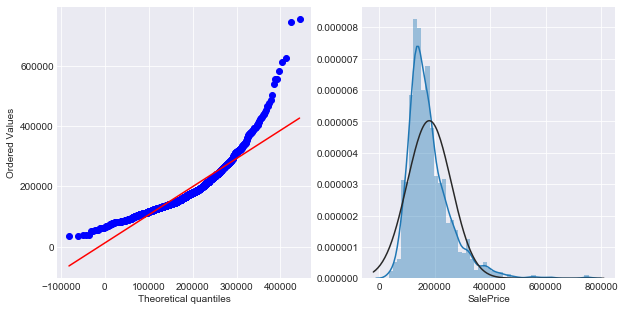

In [16]:
# using option `fit = norm` to compare the data to the theoretical distribution
from scipy.stats import norm

fig, ax = plt.subplots(1,2, figsize=(10,5))
stats.probplot(train['SalePrice'], plot=ax[0], sparams=(mu, sigma))
sns.distplot(SalePrice, kde=True ,fit=norm, ax=ax[1], axlabel='SalePrice') 
ax[0].set_title('') # remove plot title

**<span style="color:#212F3D">qq-plot completed explained</span>**<br/>
[step by step on how to draw a qq-plot](http://www.statisticshowto.com/q-q-plots/)<br/>
[qq-plot another explanation](http://onlinestatbook.com/2/advanced_graphs/q-q_plots.html)<br/>
[using scipy to draw a qq-plot](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html)


<a id="06"></a>
## <span style="color:#922B21">6. Visualize all numerical features' distribution</span>

In [17]:
def numCol(df, data_type=[]):
    '''return numerical column names for distribution visualization'''
    num_col = []
    for x in df.columns.values:
        if df[x].dtype in data_type:
            num_col.append(x)
    return num_col

num_col = numCol(all_data_sub_impute, data_type=[int,float])
print('number of num_col:', len(num_col))
print(num_col)

number of num_col: 50
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Fence', 'MiscVal', 'MoSold', 'YrSold']


ax len: 100


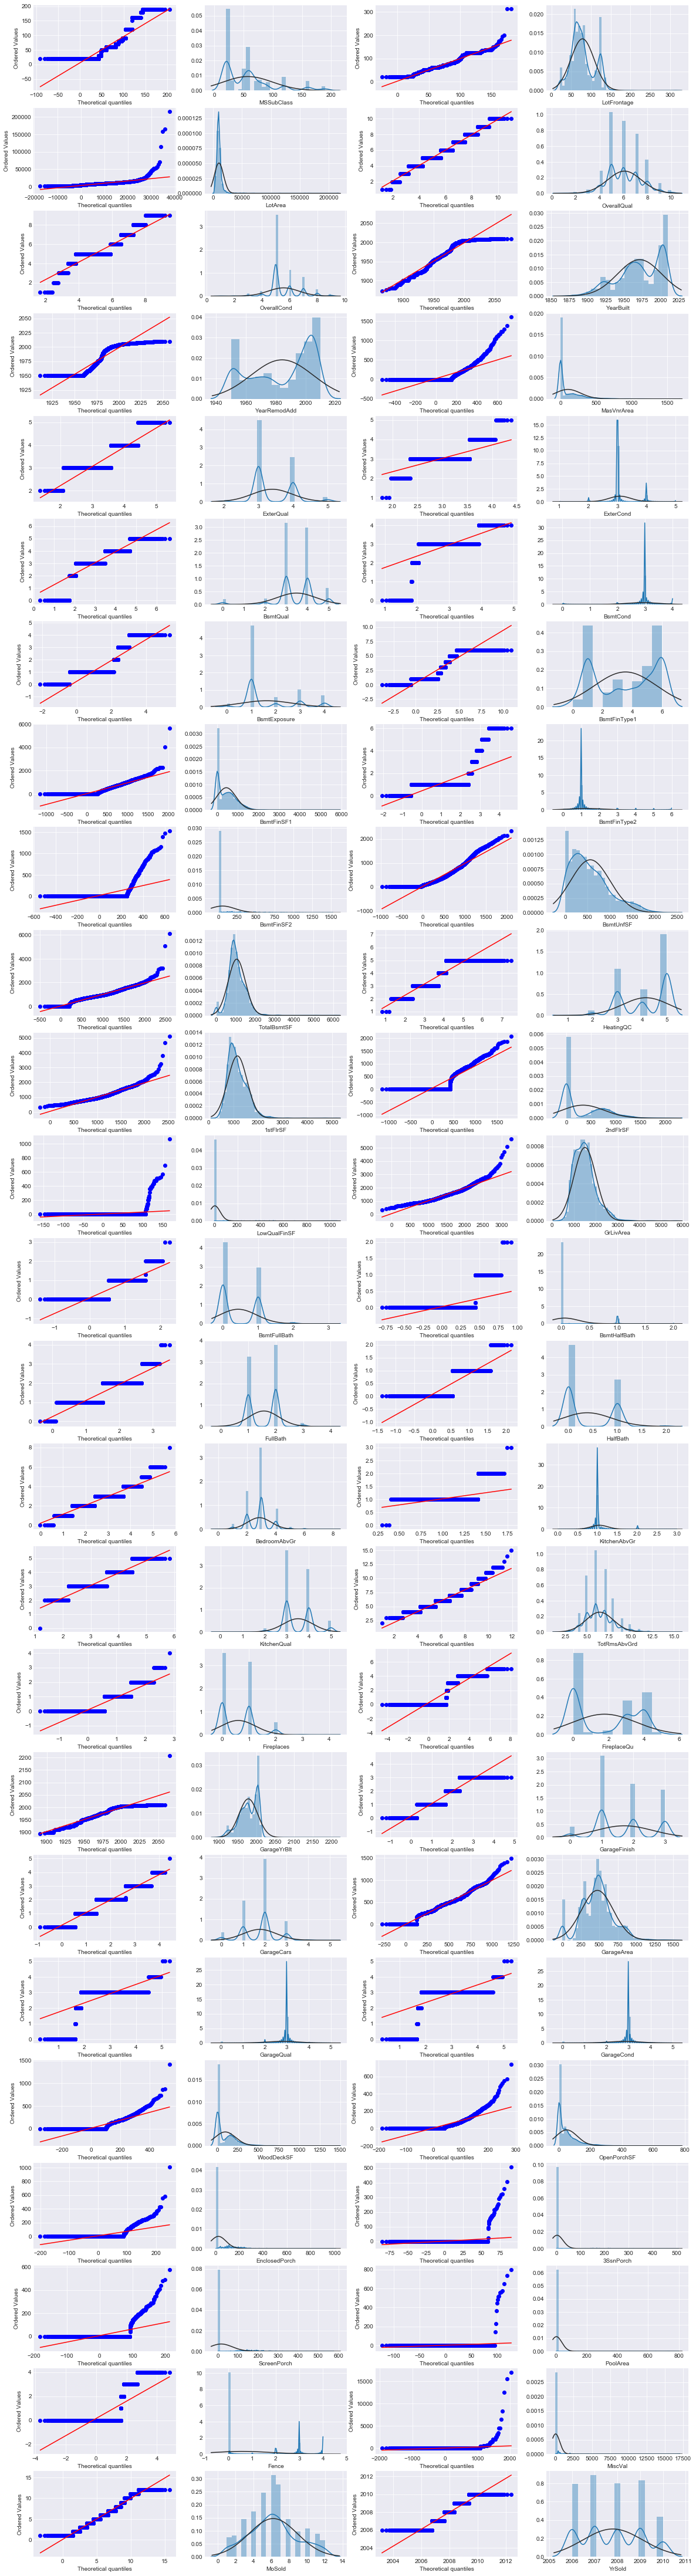

In [18]:
import math

def printChart(df, num_col):
    '''print the distribution of num_col from df'''
    fig, ax = plt.subplots(math.ceil(len(num_col)/2),4, figsize=(20,80))
    ax = ax.flatten()
    print('ax len:',len(ax))
    
    index = 0
    for x in num_col:
        (mu, sigma) = norm.fit(df[x])
        stats.probplot(df[x],plot=ax[index],sparams=(mu,sigma))
        ax[index].set_title('') # remove plot title
        index = index + 1
        sns.distplot(df[x], kde=True, fit=norm, ax=ax[index])
        index = index + 1
        
printChart(all_data_sub_impute, num_col)

>**<span style="color:#922B21">QUESTION</span>**<br/>
If we define to draw the plot within the function, is it always the case that the plot will show up in jupyter notebook output panel, or we need to configure setting so that the plot won't loss out when the function is completed ? For example, in this code panel, I specify **fig and ax**, how can I sure these will be directed to the final fig and ax output correctly ? As in this case, I don't know why it works.  

<a id="07"></a>
### <span style="color:#922B21">7. Normality Test on target and numerical features</span>

> <span style="color:#1F618D">NOTICE: columns `YearBuilt`, `YearRemodAdd`, `GarageYrBlt` are excluded from boxcox transformation particularly, because their transformed value will be too large to fit in some models, such as SVR, Decision Tree.</span>

In [19]:
from scipy.stats import shapiro

# check up the target variable
SalePrice_statisitcs, SalePrice_p = shapiro(SalePrice)
print('data SalePrice does not look Gaussian (reject H0):', SalePrice_p < 0.05)

# check up the input features
def checkNormality(df, col):
    '''check normality for col and return non-normal distributed column names'''
    non_normal_col = []
    for x in col:
        statisitcs, p = shapiro(df[x])
        if p < 0.05:
            print('data {} does not look Gaussian (reject H0)'.format(x))
            non_normal_col.append(x)
        else:
            continue
    return non_normal_col

# for 'YearBuilt','YearRemodAdd','GarageYrBlt', remove them for boxcox transformation
# because their boxcox transformed values are too big and won't be able to serve as input for SVR, Decision Tree etc. 
boxcox_col = checkNormality(all_data_sub_impute, num_col)
boxcox_col.remove('YearBuilt')
boxcox_col.remove('YearRemodAdd')
boxcox_col.remove('GarageYrBlt')

data SalePrice does not look Gaussian (reject H0): True
data MSSubClass does not look Gaussian (reject H0)
data LotFrontage does not look Gaussian (reject H0)
data LotArea does not look Gaussian (reject H0)
data OverallQual does not look Gaussian (reject H0)
data OverallCond does not look Gaussian (reject H0)
data YearBuilt does not look Gaussian (reject H0)
data YearRemodAdd does not look Gaussian (reject H0)
data MasVnrArea does not look Gaussian (reject H0)
data ExterQual does not look Gaussian (reject H0)
data ExterCond does not look Gaussian (reject H0)
data BsmtQual does not look Gaussian (reject H0)
data BsmtCond does not look Gaussian (reject H0)
data BsmtExposure does not look Gaussian (reject H0)
data BsmtFinType1 does not look Gaussian (reject H0)
data BsmtFinSF1 does not look Gaussian (reject H0)
data BsmtFinType2 does not look Gaussian (reject H0)
data BsmtFinSF2 does not look Gaussian (reject H0)
data BsmtUnfSF does not look Gaussian (reject H0)
data TotalBsmtSF does not 

In [20]:
# transform `SalePrice`
SalePrice_boxcox, SalePrice_maxlog = stats.boxcox(1 + SalePrice)

# implement normality test again
SalePrice_boxcox_statistics, SalePrice_boxcox_p = stats.shapiro(SalePrice_boxcox)
print('P value:', SalePrice_boxcox_p)
print('data SalePrice_boxcox does not look Gaussian (reject H0):', SalePrice_boxcox_p < 0.05)

P value: 1.9092685477062332e-07
data SalePrice_boxcox does not look Gaussian (reject H0): True


**<span style="color:#78281F">Even after Boxcox transformation, SalePrice still does not pass the Normality test. Nonetheless, the plot shows the skewness improves somehow.</span>**

SalePrice Skewness: 1.880940746034036
SalePrice_boxcox Skewness: -0.008644777520972145


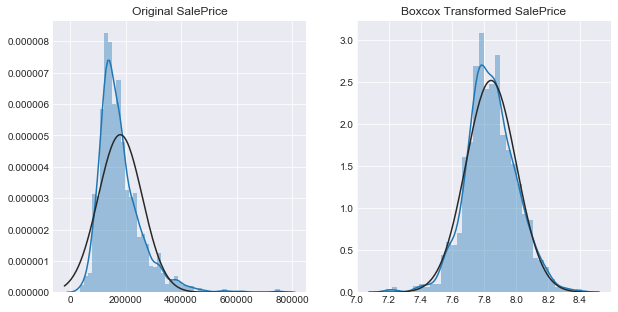

In [21]:
print('SalePrice Skewness:', skew(SalePrice))
print('SalePrice_boxcox Skewness:', skew(SalePrice_boxcox))

fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.distplot(SalePrice, kde=True, fit=norm, ax=ax[0])
ax[0].set_title('Original SalePrice')
sns.distplot(SalePrice_boxcox, kde=True, fit=norm, ax=ax[1])
ax[1].set_title('Boxcox Transformed SalePrice')

**<span style="color:#78281F">Transform The Numerical Input Features</span>**

In [22]:
# transform numerical input features
from pprint import pprint
def transBoxcox(df, boxcox_col):
    '''return boxcox transformed df and the lmbda of respective column for boxcox'''
    df = df.copy()
    boxcox_maxlog = {}
    for x in boxcox_col:
        array, maxlog = stats.boxcox(1 + df[x])
        df[x] = array
        boxcox_maxlog[x] = maxlog
    return df, boxcox_maxlog

all_data_sub_impute_boxcox , boxcox_maxlog = transBoxcox(all_data_sub_impute, boxcox_col)

# print subset data
pprint(dict((k,boxcox_maxlog[k]) for k in ('1stFlrSF','2ndFlrSF')))
all_data_sub_impute_boxcox.head(n=5)

{'1stFlrSF': -8.16922204235409, '2ndFlrSF': -0.13471855643133893}


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,DataSet
0,2.664,RL,12.827,0.122,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,4.931,3.010,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,2.968,0.660,1.267,PConc,11.991,28.417,0.582,4.433,15.057,0.523,0.000,20.241,212.591,GasA,54.649,Y,SBrkr,0.122,4.433,0.000,0.122,0.429,0.000,1.472,0.347,2.549,0.428,2.120,2.080,Typ,0.000,0.000,Attchd,2003.000,1.616,2.309,193.889,57.115,68.489,Y,0.000,4.308,0.000,0.000,0.000,0.000,0.000,0.000,1.697,0.122,WD,Normal,train
1,2.193,RL,14.314,0.122,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,4.341,4.193,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,0.630,1.267,CBlock,11.991,28.417,1.092,3.800,16.544,0.523,0.000,27.992,285.067,GasA,54.649,Y,SBrkr,0.122,0.000,0.000,0.122,0.000,0.042,1.472,0.000,2.549,0.428,1.755,1.854,Typ,0.583,1.326,Attchd,1976.000,1.616,2.309,168.412,57.115,68.489,Y,4.567,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.742,0.122,WD,Normal,train
2,2.664,RL,13.138,0.122,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,4.931,3.010,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,2.915,0.660,1.267,PConc,11.991,28.417,0.838,4.433,13.484,0.523,0.000,34.588,224.502,GasA,54.649,Y,SBrkr,0.122,4.439,0.000,0.122,0.429,0.000,1.472,0.347,2.549,0.428,2.120,1.854,Typ,0.583,1.326,Attchd,2001.000,1.616,2.309,210.789,57.115,68.489,Y,0.000,3.911,0.000,0.000,0.000,0.000,0.000,0.000,6.084,0.122,WD,Normal,train
3,2.722,RL,12.291,0.122,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,4.931,3.010,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,0.630,1.267,BrkTil,7.495,59.391,0.582,3.800,10.495,0.523,0.000,38.536,193.525,GasA,32.574,Y,SBrkr,0.122,4.384,0.000,0.122,0.429,0.000,0.831,0.000,2.549,0.428,2.120,1.974,Typ,0.583,1.529,Detchd,1998.000,0.880,3.623,220.217,57.115,68.489,Y,0.000,3.719,0.769,0.000,0.000,0.000,0.000,0.000,1.697,0.122,WD,Abnorml,train
4,2.664,RL,14.685,0.122,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,5.502,3.010,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,3.117,0.660,1.267,PConc,11.991,28.417,0.989,4.433,14.731,0.523,0.000,36.731,264.867,GasA,54.649,Y,SBrkr,0.122,4.517,0.000,0.122,0.429,0.000,1.472,0.347,3.295,0.428,2.120,2.174,Typ,0.583,1.326,Attchd,2000.000,1.616,3.623,272.285,57.115,68.489,Y,4.286,4.653,0.000,0.000,0.000,0.000,0.000,0.000,7.680,0.122,WD,Normal,train


**[normality test 01](https://plot.ly/python/normality-test/)**<br/>
**[normality test 02](https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/)**<br/>
**[python break, continue, pass](https://www.digitalocean.com/community/tutorials/how-to-use-break-continue-and-pass-statements-when-working-with-loops-in-python-3)**<br/>
**[extract subset of key-value pairs from Python dictionary object?](https://stackoverflow.com/questions/5352546/extract-subset-of-key-value-pairs-from-python-dictionary-object)**

**<span style="color:#78281F">Here we can tell, after Boxcox transformation, the skewness of these numerical columns improves.</span>**

In [23]:
# comparison of skewness of before and after on input features
skew_dataset = pd.DataFrame({'A_inputOriginalSkew':skew(all_data_sub_impute[boxcox_col]),
                             'B_inputBoxcoxSkew':skew(all_data_sub_impute_boxcox[boxcox_col])},
                            index=boxcox_col)
print(skew_dataset[:5])

             A_inputOriginalSkew  B_inputBoxcoxSkew
MSSubClass                 1.375              0.070
LotFrontage                0.750              0.013
LotArea                   12.822              0.000
OverallQual                0.197              0.020
OverallCond                0.570              0.091


<a id="08"></a>
## <span style="color:#922B21">8. Create Dummy Variables for All Categorical Features and Split Out Train and Test Dataset.</span>

In [24]:
# create dummy
all_data_sub_impute_boxcox_dummy = pd.get_dummies(all_data_sub_impute_boxcox)
all_data_sub_impute_boxcox_dummy.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond',
       ...
       'SaleType_Oth', 'SaleType_WD', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'DataSet_test',
       'DataSet_train'],
      dtype='object', length=231)

In [25]:
# split out train and test dataset
train_impute_boxcox = all_data_sub_impute_boxcox_dummy[all_data_sub_impute_boxcox_dummy['DataSet_train'] == 1]
train_impute_boxcox.drop(columns=['DataSet_train','DataSet_test'], inplace=True)
test_impute_boxcox = all_data_sub_impute_boxcox_dummy[all_data_sub_impute_boxcox_dummy['DataSet_test'] == 1]
test_impute_boxcox.drop(columns=['DataSet_train','DataSet_test'], inplace=True)

In [26]:
print('train dataset shape:',train_impute_boxcox.shape)
print('test dataset shape:',test_impute_boxcox.shape)

train dataset shape: (1460, 229)
test dataset shape: (1459, 229)


**<span style="color:#78281F">Now after we complete the data pre-processing, we can ignore the test dataset, for it doesn't contain the target sale price as reference to check up in this practice. I will exclude test data, and use `train_test_split` to split test data out from original training data particularly.</span>**

In [27]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(train_impute_boxcox, SalePrice_boxcox, 
                                                    test_size = 0.2, random_state = 120)

In [28]:
# shape of new training and test dataset
print('new train dataset shape:',train_x.shape)
print('new test dataset shape:',test_x.shape)

new train dataset shape: (1168, 229)
new test dataset shape: (292, 229)


<a id="09"></a>
## <span style="color:#922B21">9. Single Modeling with Hyper Paramater GridSearch Used</span>

**[python convert string to an object](https://stackoverflow.com/questions/1176136/convert-string-to-python-class-object)**

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
from sklearn.metrics import make_scorer, r2_score

def fitGridModel(model, params, train_x, train_y):
    '''define a function to implement GridSearch all in one'''
    reg_model = model
    best_params = {}
    
    scorer = make_scorer(r2_score, greater_is_better=True)
    grid = GridSearchCV(reg_model, param_grid=params, scoring=scorer, cv=5)
    grid.fit(train_x, train_y)
    score = grid.best_score_
    print("the best R^2 of all model parameters' combination on model: {:.4f}".format(score))
    best_params.update(grid.best_params_)
    print("the parameter setting of optimized model:", grid.best_estimator_)
    
    return score, best_params, grid

In [31]:
# Lasso
las_score, las_params, las_grid_model = fitGridModel(model=Lasso(), 
                                                     params = {"alpha":[0.1,0.001,0.0001,0.00005,0.00001],
                                                               "max_iter":[500,100,80,60],
                                                               "random_state":[120]},
                                                     train_x=train_x,
                                                     train_y=train_y)


the best R^2 of all model parameters' combination on model: 0.8525
the parameter setting of optimized model: Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=80,
   normalize=False, positive=False, precompute=False, random_state=120,
   selection='cyclic', tol=0.0001, warm_start=False)


In [32]:
# AdaBoost
adab_score, adab_params, adab_grid_model = fitGridModel(model=AdaBoostRegressor(),
                                                        params = {"n_estimators":[200,180,150,130,100],
                                                                  "learning_rate":[0.35,0.3,0.25,0.2,0.15],
                                                                  "random_state":[120]},
                                                        train_x = train_x,
                                                        train_y = train_y)

the best R^2 of all model parameters' combination on model: 0.7984
the parameter setting of optimized model: AdaBoostRegressor(base_estimator=None, learning_rate=0.25, loss='linear',
         n_estimators=180, random_state=120)


In [33]:
# SVR
svr_score, svr_params, svr_grid_model = fitGridModel(model=SVR(),
                                                     params = {'C':[7.5, 8, 8.5, 9, 9.5, 10],
                                                               'gamma':[0.000001, 0.00001, 0.0001, 0.001]},
                                                     train_x = train_x,
                                                     train_y = train_y)

the best R^2 of all model parameters' combination on model: 0.7816
the parameter setting of optimized model: SVR(C=9.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1e-05,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [36]:
# XGBoost
xgb_score, xgb_params, xgb_grid_model = fitGridModel(xgb.XGBRegressor(),
                                                     params = {'learning_rate': [0.65,0.7],
                                                               'max_depth': [1,2],
                                                               'colsample_bytree':[0.8,0.85],
                                                               'n_estimators':[300,350],
                                                               'random_state':[120]},
                                                     train_x = train_x,
                                                     train_y = train_y)

the best R^2 of all model parameters' combination on model: 0.8620
the parameter setting of optimized model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, gamma=0, learning_rate=0.7, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=350,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=120,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [37]:
# collect the best params for each model
params = {Lasso.__name__:las_params,
          xgb.XGBRegressor.__name__: xgb_params,
          SVR.__name__: svr_params}
print(params)

{'Lasso': {'alpha': 0.0001, 'max_iter': 80, 'random_state': 120}, 'XGBRegressor': {'colsample_bytree': 0.85, 'learning_rate': 0.7, 'max_depth': 1, 'n_estimators': 350, 'random_state': 120}, 'SVR': {'C': 9.5, 'gamma': 1e-05}}


**[\*args and \*\*keyargs explained](https://pythontips.com/2013/08/04/args-and-kwargs-in-python-explained/)**

<a id="10"></a>
## <span style="color:#922B21">10. Stacking Model</span>

**10.a Use Average Base Model**

In [38]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.model_selection import KFold

class averageCVBaseModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    
    def fit(self, X, y, params=None):
        self.models_ = []
        
        for m in self.models:
            if params is None:
                reg = m()
            else:
                params_value = params[m.__name__]
                reg = m(**params_value)
            reg.fit(X,y)
            self.models_.append(reg)
        
        return self
    
    def predict(self, X):
        predict_dataset = np.column_stack([reg.predict(X) for reg in self.models_])
        return np.mean(predict_dataset, axis = 1)
    
    def cvScore(self, X, y, n_folds, params=None):
        '''define to implement cross-validation for X and return r2 score'''
        kfold = KFold(n_splits=n_folds, shuffle=True)
        cv_scores = []
        
        for train_idx, valid_idx in kfold.split(X):
            train_x = X.iloc[train_idx,:]
            train_y = y[train_idx]
            valid_x = X.iloc[valid_idx,:]
            
            self.cv_models_ = []
            for m in self.models:
                if params is None:
                    reg = m()
                else:
                    params_value = params[m.__name__]
                    reg = m(**params_value)
                reg.fit(train_x,train_y)
                self.cv_models_.append(reg)
            
            predict_dataset = np.column_stack([reg.predict(valid_x) for reg in self.cv_models_])
            predict_dataset = np.mean(predict_dataset, axis = 1)
            r2 = r2_score(y[valid_idx], predict_dataset)
            cv_scores.append(r2)
        
        print('score in each fold:', cv_scores)
        return np.mean(cv_scores)
    
    def cvScoreThreeModelUnevenWeights(self, X, y, n_folds, params=None):
        '''define to implement cross-validation based on uneven weights
            for each model's prediction, 3 weights only, and return the mean
            cross-validation score under each weight set'''
        cv_scores_weighted = []
        for alpha in np.linspace(0.1, 0.9, 5, endpoint=False):
            for beta in np.linspace(0.1, (1-alpha), 5, endpoint=False):
                gamma = 1 - alpha - beta
        
                kfold = KFold(n_splits=n_folds, shuffle=True)
                cv_scores = []
        
                for train_idx, valid_idx in kfold.split(X):
                    train_x = X.iloc[train_idx,:]
                    train_y = y[train_idx]
                    valid_x = X.iloc[valid_idx,:]
            
                    self.cv_models_ = []
                    for m in self.models:
                        if params is None:
                            reg = m()
                        else:
                            params_value = params[m.__name__]
                            reg = m(**params_value)
                        reg.fit(train_x,train_y)
                        self.cv_models_.append(reg)
            
                    predict_dataset = np.column_stack([reg.predict(valid_x) for reg in self.cv_models_])
                
                    predict_dataset_weighted = alpha*predict_dataset[:,0] + \
                                               beta*predict_dataset[:,1] + \
                                               gamma*predict_dataset[:,2]
                    r2 = r2_score(y[valid_idx], predict_dataset_weighted)
                    cv_scores.append(r2)
                    
                cv_scores_weighted.append((alpha, beta, gamma, np.mean(cv_scores)))
        cv_scores_weighted = pd.DataFrame(cv_scores_weighted,
                                          columns=['alpha','beta','gamma','cv_score'])
        return cv_scores_weighted
        

>**<span style="color:#922B21">QUESTION</span>**<br/>
When we create a class, why we don't need to use **return** keyword in the def __init__(), instead, in other functions, either we return a value, or we use **return self** somehow?

**[What does KFold in python exactly do?](https://stackoverflow.com/questions/36063014/what-does-kfold-in-python-exactly-do)**<br/>
**[Pass a dict to scikit learn estimator](https://stackoverflow.com/questions/33110973/pass-a-dict-to-scikit-learn-estimator)**<br/>
**[如何在 Kaggle 首战中进入前 10%](https://dnc1994.com/2016/04/rank-10-percent-in-first-kaggle-competition/)**<br/>
**[What is your cross-validation method?](https://www.kaggle.com/c/telstra-recruiting-network/discussion/19277)**

In [39]:
# create an ensemble base model
avg_base_model = averageCVBaseModel(models = [Lasso, xgb.XGBRegressor, SVR])

In [40]:
# model with default parameter
avg_base_model.cvScore(X=train_x, y=train_y, n_folds=5,params=None)

score in each fold: [0.71570469738655951, 0.65239013999422091, 0.66435975893371901, 0.66904361072010055, 0.66365365833834467]


0.67303037307458902

In [41]:
# model with optimized parameters
avg_base_model.cvScore(X=train_x, y=train_y, n_folds=5,params=params)

score in each fold: [0.86002934552328225, 0.88686619228333485, 0.92040913419623949, 0.79290981405436067, 0.90145825540276214]


0.87233454829199586

In [42]:
# find out the best weight set for ensemble base model
best_weight_set = avg_base_model.cvScoreThreeModelUnevenWeights(X=train_x, 
                                                                y=train_y,
                                                                n_folds=5,
                                                                params=params)

In [43]:
print('top five weight set for cv score: \n', 
      best_weight_set.iloc[np.argsort(best_weight_set['cv_score'])][::-1][:5])

top five weight set for cv score: 
     alpha  beta  gamma  cv_score
16  0.580 0.164  0.256     0.882
17  0.580 0.228  0.192     0.881
4   0.100 0.740  0.160     0.880
13  0.420 0.388  0.192     0.880
20  0.740 0.100  0.160     0.879


**10.b Use Stacking Model from mlxtend**

In [44]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

RANDOM_SEED = 120

# The StackingCVRegressor uses scikit-learn's check_cv
# internally, which doesn't support a random seed. Thus
# NumPy's random seed need to be specified explicitely for
# deterministic behavior

# use the optimized parameters from above
lasso = Lasso(random_state=RANDOM_SEED, alpha=0.0001, max_iter=80)
xgb_model = xgb.XGBRegressor(random_state = RANDOM_SEED, colsample_bytree=0.85,
                             learning_rate=0.7, max_depth=1, 
                             n_estimators=350)
svr = SVR(C=9.5, gamma=0.00001)
linear = LinearRegression() # meta-model

np.random.seed(RANDOM_SEED)
stack = StackingCVRegressor(regressors = (lasso, xgb_model, svr),
                            meta_regressor = linear)


stack_scores = cross_val_score(stack, train_x.as_matrix(), train_y, cv=5)

print("R^2 Score: %0.2f (+/- %0.2f)" %(stack_scores.mean(), stack_scores.std()))

R^2 Score: 0.87 (+/- 0.02)


**<span style="color:#78281F">As it seems like adding meta-model doesn't has any effect on improving the prediction performance.(the base model has 0.87 R2, the same as stacking meta model)</span>**

**For reference: This code for grid-search using mlxtend module won't be run for it takes up too much time. It is written for reference only.**

In [ ]:
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

RANDOM_SEED = 120

# The StackingCVRegressor uses scikit-learn's check_cv
# internally, which doesn't support a random seed. Thus
# NumPy's random seed need to be specified explicitely for
# deterministic behavior

# use the optimized parameters from above
lasso = Lasso(random_state=RANDOM_SEED)
xgb_model = xgb.XGBRegressor(random_state = RANDOM_SEED)
svr = SVR()
linear = LinearRegression() # meta-model

np.random.seed(RANDOM_SEED)
stack = StackingCVRegressor(regressors = (lasso, xgb_model, svr),
                            meta_regressor = linear)

# the code for grid sreach
# for it taks up so much time, I will not run this model, but it serves as a document
params_mlx = {"lasso__alpha":[0.1,0.001,0.0001,0.00005,0.00001],
              "lasso__max_iter":[500,100,80,60],
              "xgbregressor__learning_rate": [0.65,0.7,0.75,0.8,0.85],
              "xgbregressor__max_depth": [1,2,3],
              "xgbregressor__colsample_bytree":[0.8,0.85, 0.9],
              "xgbregressor__n_estimators":[300,350,400],
              "svr__C":[7.5, 8, 8.5, 9, 9.5, 10],
              "svr__gamma":[0.000001, 0.00001, 0.0001, 0.001]}

grid_mlx = GridSearchCV(estimator=stack,
                        param_grid = params_mlx,
                        cv = 5)


# both X,y should be numpy.array
grid_mlx.fit(train_x.as_matrix(), train_y)

print("Best: %f using %s" % (grid_mlx.best_score_, grid_mlx.best_params_))

In [45]:
# use named_regressors to get `name` of the regressor
print(stack.named_regressors)
print(stack.named_meta_regressor)

{'lasso': Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=80,
   normalize=False, positive=False, precompute=False, random_state=120,
   selection='cyclic', tol=0.0001, warm_start=False), 'xgbregressor': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, gamma=0, learning_rate=0.7, max_delta_step=0,
       max_depth=1, min_child_weight=1, missing=None, n_estimators=350,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=120,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1), 'svr': SVR(C=9.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1e-05,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)}
{'meta-linearregression': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)}


In [46]:
# get parameter key for the model
AdaBoostRegressor().get_params().keys()

dict_keys(['base_estimator', 'learning_rate', 'loss', 'n_estimators', 'random_state'])

**[get the name of regressors: self.named_regressors](https://github.com/rasbt/mlxtend/blob/master/mlxtend/regressor/stacking_cv_regression.py)**<br/>
**[get the parameter key of model: step.get_params().keys()](https://github.com/rasbt/mlxtend/blob/master/mlxtend/regressor/stacking_cv_regression.py)**<br/>
**[convert a list of lists into a Pandas Dataframe](https://datascience.stackexchange.com/questions/26333/convert-a-list-of-lists-into-a-pandas-dataframe)**<br/>
**[how to get 2D array column length?](https://stackoverflow.com/questions/7670226/python-numpy-how-to-get-2d-array-column-length)**

<a id="11"></a>
## <span style="color:#922B21">11. Compare The Performances and Predict Outcome</span>

**1. Best Single Model: XGBoost - performance on test dataset**

In [54]:
# XGBoost model on test dataset
prediction = xgb_grid_model.predict(test_x)
print('single model XGBoost R2:',r2_score(test_y, prediction))

single model XGBoost R2: 0.905091482396


In [55]:
from scipy.special import inv_boxcox
print('sale price boxcox lmbda:',SalePrice_maxlog)

sale price boxcox lmbda: -0.0769321020864


In [56]:
outcome = pd.DataFrame(np.column_stack((inv_boxcox(test_y, SalePrice_maxlog), 
                                        inv_boxcox(prediction, SalePrice_maxlog))),
                       columns = ['original_y', 'predicted_y'])

In [57]:
print('R2 on original scale:',r2_score(outcome.original_y, outcome.predicted_y))

R2 on original scale: 0.913399666829


**2. Average Base Model with Default Parameters - performance on test dataset**

In [58]:
avg_base_model.fit(train_x, train_y)
prediction = avg_base_model.predict(test_x)
print('Average Base Model R2:',r2_score(test_y, prediction))

Average Base Model R2: 0.701104199633


In [59]:
outcome = pd.DataFrame(np.column_stack((inv_boxcox(test_y, SalePrice_maxlog), 
                                        inv_boxcox(prediction, SalePrice_maxlog))),
                       columns = ['original_y', 'predicted_y'])

In [60]:
print('R2 on original scale:',r2_score(outcome.original_y, outcome.predicted_y))

R2 on original scale: 0.637057799105


**3. Average Base Model with Optimized Parameters - performance on test dataset**

In [62]:
avg_base_model.fit(train_x, train_y, params=params)
prediction = avg_base_model.predict(test_x)
print('Average Base Model with Optimized Parameters R2:',r2_score(test_y, prediction))

Average Base Model with Optimized Parameters R2: 0.918259061003


In [63]:
outcome = pd.DataFrame(np.column_stack((inv_boxcox(test_y, SalePrice_maxlog), 
                                        inv_boxcox(prediction, SalePrice_maxlog))),
                       columns = ['original_y', 'predicted_y'])

In [64]:
print('R2 on original scale:',r2_score(outcome.original_y, outcome.predicted_y))

R2 on original scale: 0.917657950719


**4. Stacking Meta Model with Optimized Parameters - performance on test dataset**

In [67]:
stack.fit(train_x.as_matrix(), train_y)
prediction = stack.predict(test_x.as_matrix())
print('Stacking Meta Model with Optimized Parameters R2:',r2_score(test_y, prediction))

Stacking Meta Model with Optimized Parameters R2: 0.923952148391


In [68]:
outcome = pd.DataFrame(np.column_stack((inv_boxcox(test_y, SalePrice_maxlog), 
                                        inv_boxcox(prediction, SalePrice_maxlog))),
                       columns = ['original_y', 'predicted_y'])

In [69]:
print('R2 on original scale:',r2_score(outcome.original_y, outcome.predicted_y))

R2 on original scale: 0.925772645737


**<span style="color:#78281F">It turns out that the stacking model has the best result on test dataset, so I will choose it as the final model.(the single XGBoost model has 0.91 R2, which is quite good as well)</span>**

In [70]:
# have a look at y in original sacle
outcome.head(n=10)

,original_y,predicted_y
0,197001.000,196373.508
1,176501.000,185409.779
2,125001.000,130313.711
3,262001.000,276975.238
4,119201.000,122233.663
5,128201.000,128789.802
6,211001.000,216727.063
7,87001.000,91260.084
8,159001.000,172831.615
9,175001.000,155588.644


In [73]:
# calculate the mean squared error
from sklearn.metrics import mean_squared_error
print('square root of mean squared error',math.sqrt(mean_squared_error(outcome.original_y, outcome.predicted_y)))

square root of mean squared error 21935.37172997225
